In [1]:
import sys
if sys.version_info[0] < 3:
  print('[ERROR] You need to run this with Python 3.')
  raise AssertionError

# ______________________________________________________________________________
import numpy as np

from emtf_algos import *
from emtf_logger import *

In [2]:
import sys
import os
#os.environ['KERAS_BACKEND'] = 'tensorflow'

# Set random seed
np.random.seed(2027)

import tensorflow as tf
import tensorflow.keras as keras
import matplotlib as mpl
import matplotlib.pyplot as plt

# Set random seed
tf.random.set_seed(2027)

import numba
from numba import njit, vectorize
import dask
import dask.array as da

logger = get_logger()
logger.info('Using cmssw      : {0}'.format(os.environ['CMSSW_VERSION'] if 'CMSSW_VERSION' in os.environ else 'n/a'))
logger.info('Using python     : {0}'.format(sys.version.replace('\n', '')))
logger.info('Using numpy      : {0}'.format(np.__version__))
logger.info('Using tensorflow : {0}'.format(tf.__version__))
logger.info('Using keras      : {0}'.format(keras.__version__))
logger.info('.. list devices  : {0}'.format(tf.config.list_physical_devices()))
logger.info('Using matplotlib : {0}'.format(mpl.__version__))
logger.info('Using numba      : {0}'.format(numba.__version__))
logger.info('Using dask       : {0}'.format(dask.__version__))

%matplotlib inline

[INFO    ] Using cmssw      : CMSSW_10_6_3
[INFO    ] Using python     : 3.6.10 |Anaconda, Inc.| (default, May  8 2020, 02:54:21) [GCC 7.3.0]
[INFO    ] Using numpy      : 1.18.5
[INFO    ] Using tensorflow : 2.2.0
[INFO    ] Using keras      : 2.3.0-tf
[INFO    ] .. list devices  : [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]
[INFO    ] Using matplotlib : 3.2.2
[INFO    ] Using numba      : 0.50.1
[INFO    ] Using dask       : 2.20.0


In [3]:
# Settings

# zone: (0,1,2) -> eta=(1.98..2.5, 1.55..1.98, 1.2..1.55)
zone = 0
#zone = 1
#zone = 2

# timezone: (0,1,2) -> BX=(-1,0,+1)
timezone = 1

maxevents = 100
#maxevents = -1

# Input files
patterns_fname = 'patterns_zone%i.npz' % zone
zone_images_fname = 'zone_images_zone%i.h5' % zone

logger.info('Processing zone {0} timezone {1}'.format(zone, timezone))
logger.info('.. maxevents        : {0}'.format(maxevents))

[INFO    ] Processing zone 0 timezone 1
[INFO    ] .. maxevents        : 100


In [4]:
# Styling
plt.style.use('tdrstyle.mplstyle')

# Color maps
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(plt.cm.viridis.colors, name='viridis_mod')
my_cmap.set_under('w',1)

from matplotlib.colors import LinearSegmentedColormap
cdict = {
  'blue' : ((0.0, 0.0416, 0.0416), (0.365079, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'green': ((0.0, 0.0, 0.0), (0.365079, 0.0, 0.0), (0.746032, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'red'  : ((0.0, 0.0, 0.0), (0.746032, 0.0, 0.0), (1.0, 1.0, 1.0)),
}
blue_hot = LinearSegmentedColormap('blue_hot', cdict)

cdict = {
  'blue' : ((0.0, 0.0, 0.0), (0.365079, 0.0, 0.0), (0.746032, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'green': ((0.0, 0.0416, 0.0416), (0.365079, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'red'  : ((0.0, 0.0, 0.0), (0.746032, 0.0, 0.0), (1.0, 1.0, 1.0)),
}
green_hot = LinearSegmentedColormap('green_hot', cdict)

### Load data

In [5]:
def load_patterns(fname):
  logger.info('Loading from {0}'.format(fname))
  with np.load(fname) as loaded:
    patterns = loaded['patterns']
    boxes_act = loaded['boxes_act']
    logger.info('patterns: {0} boxes_act: {1}'.format(patterns.shape, boxes_act.shape))
  return (patterns, boxes_act)

loaded_h5 = None

def load_zone_sparse_images(fname):
  global loaded_h5
  if loaded_h5 is None:
    logger.info('Loading from {0}'.format(fname))
    import h5py
    loaded_h5 = h5py.File(fname, 'r')
  zone_sparse_images = SparseTensorValue(
      indices=loaded_h5['zone_sparse_images_indices'],
      values=loaded_h5['zone_sparse_images_values'],
      dense_shape=loaded_h5['zone_sparse_images_dense_shape']
  )
  logger.info('zone_sparse_images: {0}'.format(zone_sparse_images.dense_shape))
  return zone_sparse_images

In [6]:
def sparse_to_dense_quick(sparse, maxevents):
  dense_shape = (maxevents,) + sparse.dense_shape[1:]
  dense = np.zeros(dense_shape, dtype=sparse.dtype)
  for i in range(len(sparse.indices)):
    if sparse.indices[i, 0] >= maxevents:
      break
    tup = tuple(sparse.indices[i])
    dense[tup] = sparse.values[i]
  return dense

In [7]:
patterns, boxes_act = load_patterns(patterns_fname)

boxes_act_test = boxes_act[3]

logger.info('boxes_act_test: {0}'.format(boxes_act_test.shape))

[INFO    ] Loading from patterns_zone0.npz
[INFO    ] patterns: (7, 7, 8, 3) boxes_act: (7, 7, 8, 111, 1)
[INFO    ] boxes_act_test: (7, 8, 111, 1)


In [8]:
zone_sparse_images = load_zone_sparse_images(zone_images_fname)

zone_images_test = sparse_to_dense_quick(zone_sparse_images, maxevents)

logger.info('zone_images_test: {0}'.format(zone_images_test.shape))

[INFO    ] Loading from zone_images_zone0.h5
[INFO    ] zone_sparse_images: (762362, 8, 300, 1)
[INFO    ] zone_images_test: (100, 8, 300, 1)


### Sliding window

In [9]:
# Apply sliding window

from numba import njit

# Set the number of threads
#numba.config.NUMBA_NUM_THREADS = 32

# Image format & box image format
(num_rows, num_cols, num_channels) = zone_images_test[0].shape
(num_box_rows, num_box_cols, num_box_channels) = boxes_act_test[0].shape
box_col_offset = (num_box_cols-1)//2  # (111-1)/2 = 55

@njit
def get_box_ranges(anchor_col):
  start = max(0, anchor_col - box_col_offset)
  stop = min(num_cols, anchor_col + box_col_offset + 1)
  b_start = max(0, num_box_cols - stop)
  b_stop = min(num_box_cols, num_cols - start)
  #assert len(range(start, stop)) == len(range(b_start, b_stop))
  return (start, stop, b_start, b_stop)


def apply_sliding_window():
  zone_featmaps_test = np.zeros(zone_images_test.shape[:-1] + boxes_act_test.shape[:1], dtype=np.bool)

  apply_sliding_window_jit0(zone_images_test, boxes_act_test, zone_featmaps_test)

  #zone_featmaps_test = np.moveaxis(zone_featmaps_test, 1, -1)
  #zone_featmaps_test = np.packbits(zone_featmaps_test, axis=-1)
  return zone_featmaps_test

@njit
def apply_sliding_window_jit0(zone_images_test, boxes_act_test, zone_featmaps_test):
  for i in range(zone_images_test.shape[0]):
    for j in range(boxes_act_test.shape[0]):
      apply_sliding_window_jit1(zone_images_test[i], boxes_act_test[j], zone_featmaps_test[i, :, :, j:j+1])

@njit
def apply_sliding_window_jit1(img, box, fmp):
  for anchor_col in range(img.shape[1]):
    start, stop, b_start, b_stop = get_box_ranges(anchor_col)
    for i in range(img.shape[0]):
      fmp[i, anchor_col, 0] = np.any(img[i, start:stop, 0] * box[i, b_start:b_stop, 0])

In [10]:
%%time

zone_featmaps_test = apply_sliding_window()

logger.info('zone_featmaps_test: {0}'.format(zone_featmaps_test.shape))

[INFO    ] zone_featmaps_test: (100, 8, 300, 7)


CPU times: user 1.41 s, sys: 27.4 ms, total: 1.44 s
Wall time: 1.45 s


In [11]:
# Display images

def display_image(img, cmap=blue_hot, figsize=(10,2)):
  fig, ax = plt.subplots(1, 1, figsize=figsize)
  ax.imshow(img[...,0], origin='lower', interpolation='none', aspect='auto',
            cmap=cmap, vmin=0, vmax=1.6)
  ax.set_yticks(range(len(zo_layer_labels[zone])))
  ax.set_yticklabels(zo_layer_labels[zone], fontsize=7)
  ax.grid(False)
  plt.show()

Event 0


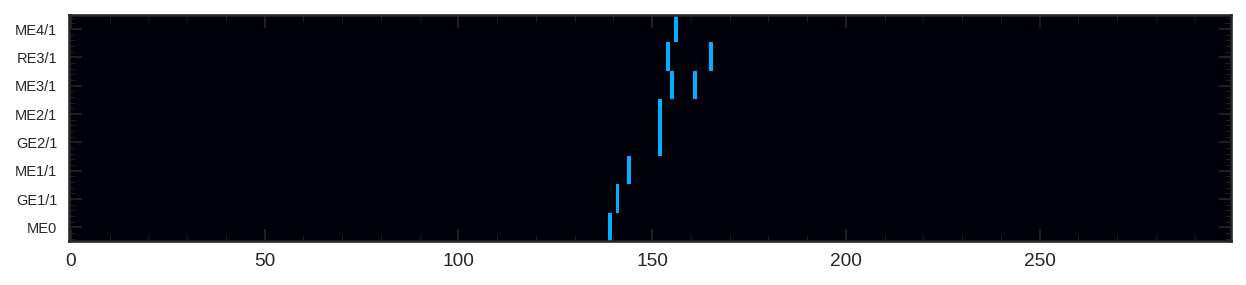

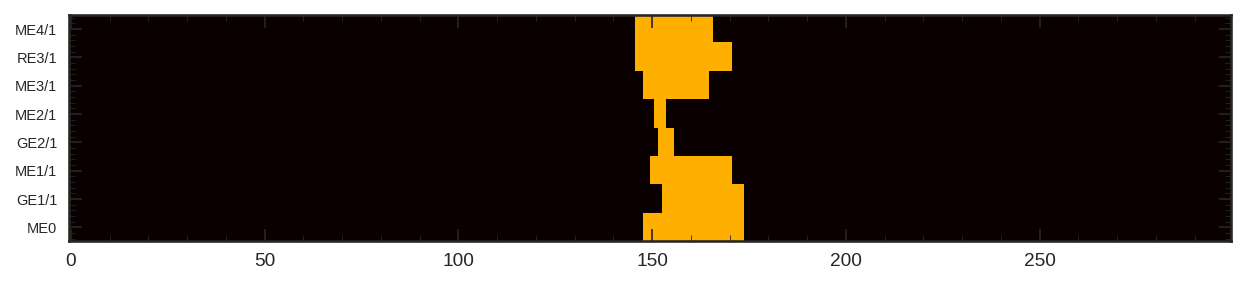

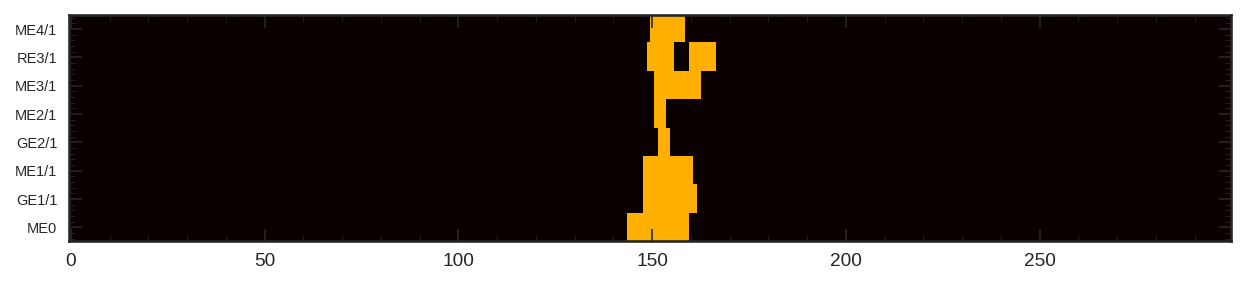

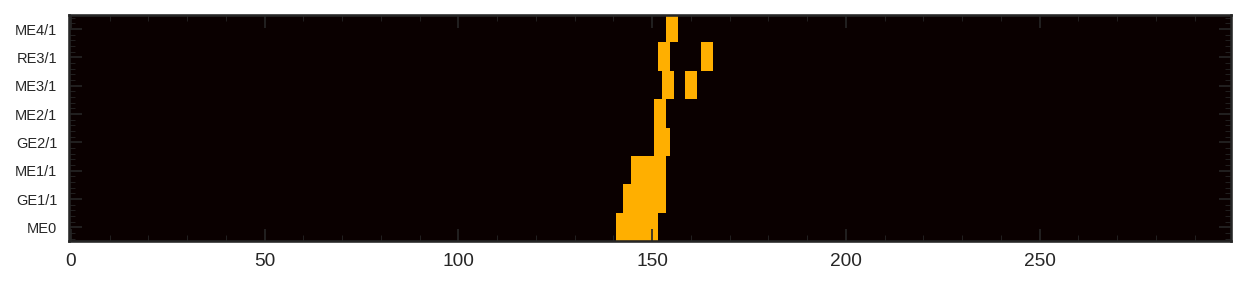

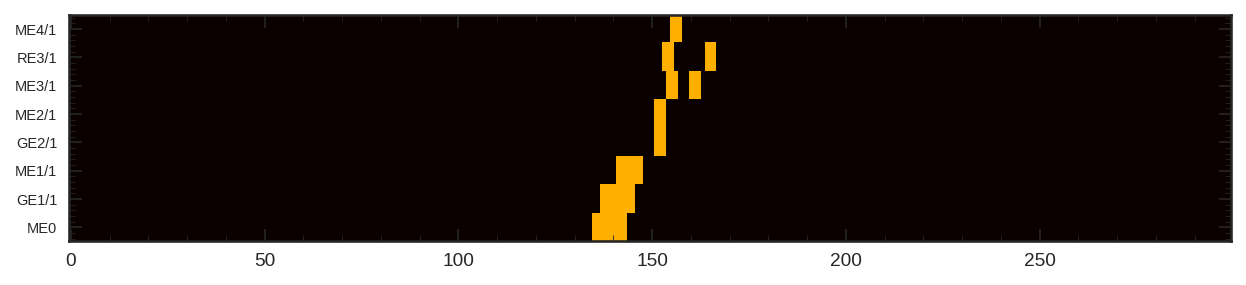

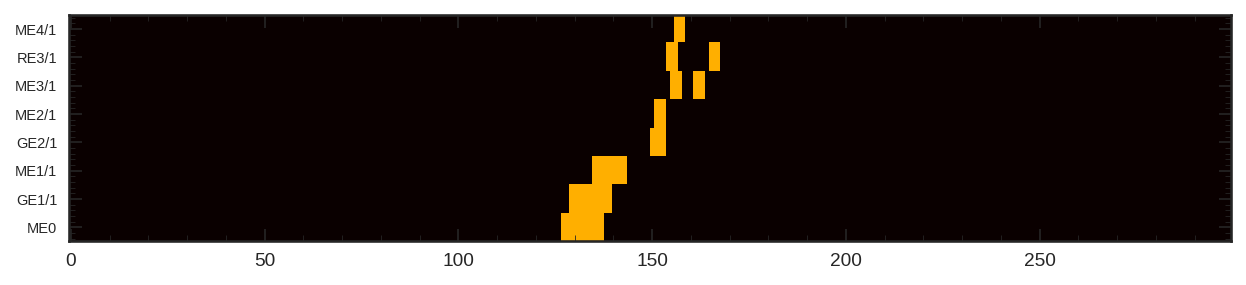

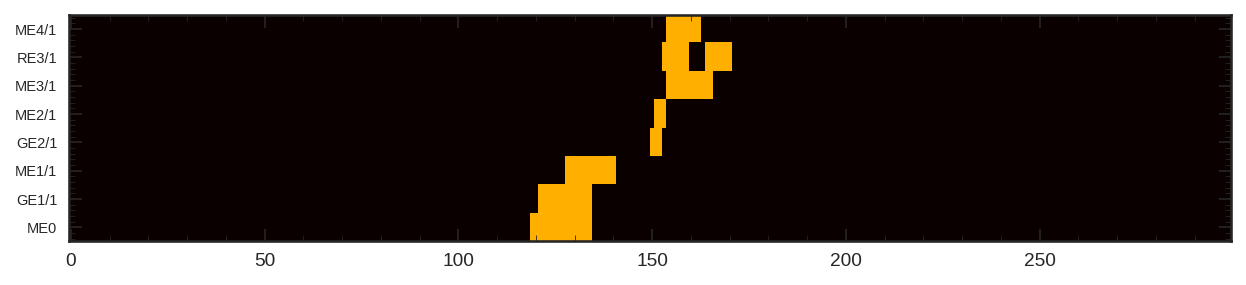

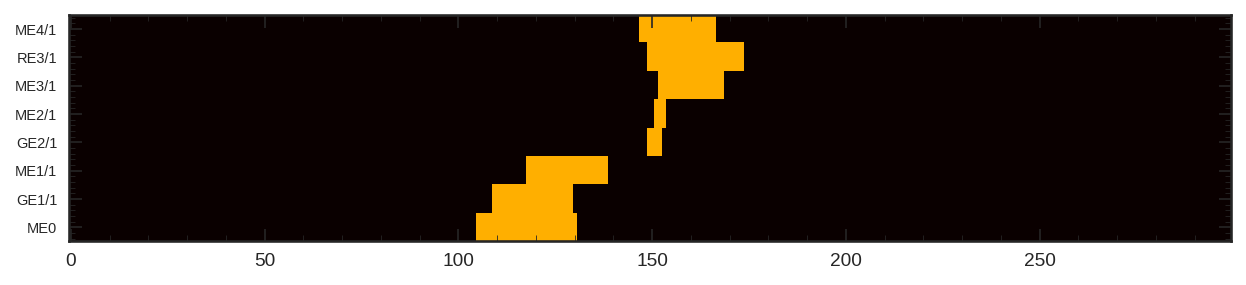

(array([0, 1, 2, 3, 4, 5, 5, 6, 6, 7]), array([139, 141, 144, 152, 152, 155, 161, 154, 165, 156]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7,
       7, 7]), array([135, 136, 137, 138, 139, 140, 141, 142, 143, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 141, 142, 143, 144, 145, 146, 147, 151,
       152, 153, 151, 152, 153, 154, 155, 156, 160, 161, 162, 153, 154,
       155, 164, 165, 166, 155, 156, 157]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0]))


In [12]:
# Debug
for ievt in range(1):
  print('Event {0}'.format(ievt))
  display_image(zone_images_test[ievt])
  for j in range(boxes_act.shape[0]):
    display_image(zone_featmaps_test[ievt][..., j:j+1], cmap=plt.cm.hot)

  print(zone_images_test[ievt].nonzero())
  print(zone_featmaps_test[ievt][..., 3:4].nonzero())